In [71]:
# from abinitio_tm import abinitio 
import numpy as np
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse



# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [80]:
# this script generates a tm as per Schiffels' equations - i.e. these are the theoretical transition probabilities

# it needs: an N_0, N_T and a lambda array which corresponds to population size per time interval

import math
import numpy as np
import pdb

def abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

def corrected_abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
                pre = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) 
#                 print('with L(alpha)^2 = {} and H_i(alpha) = {} and H_alpha(alpha)= {}'.format(L(T[alpha+1],T[alpha])**2,(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T))),(1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha)))))
                B = (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
#                 print('\n\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

# def structured_abinitio(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):  
    
#     def G(t1,t2,gamma_array,lambda_array,T):
#         """
#         Takes as input t1 and t2 in scaled coalescent time
#         t1, t2: can be boundaries or some number between a boundary
#         Needs also gamma_array and lambda_array
        
#         t1, t2: can be boundaries or some number between a boundary
#         T: array of time intervals in coalescent time
#         lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
#         gamma_array: array of population split fractions per time
        
        
#         """
#         def lower_higher_intervals(t1,t2):
#             # get the index of the next lower or equal time intervals for t1 and t2
#             ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
#             if T[ind1] > t1:
#                 ind1 = ind1 - 1
#             print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
#             ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
#             if T[ind2] > t2:
#                 ind2 = ind2 - 1
#             print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
#             return ind1, ind2

#         def G_start(t1,ind1):
#             # first part of G; see my notepad page TODO
#             G_start = 1 - ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 ) + 
#             ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2)*np.exp(-lambda_array[ind1]*(T[ind1+1] -t1))
#             return G_start
#         def G_end(t2,ind2)
#             # last part of G; see my notepad TODO
#             G_end = 1 - ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 ) + 
#             ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2)*np.exp(-lambda_array[ind2]*(t2 - ind2 ))
#             return G_end
#         def G_main(ind1,ind2):
#             # main part of G (the recursive part; the product); see my notepad page TODO
#             recursion = 1
#             for i in range(ind1+1,ind2): # TODO check ind_high range
#                 G = 1 - ( (1-gamma_array[i])**2 + (gamma_array[i]**2) ) + ( (1-gamma_array[i])**2 + (gamma_array[i]**2) )*np.exp(-(lambda_array[i]*delta[i]))
#                 recursion = recursion*G
#             return recursion
#         def G_same(t1,t2,ind1):
#             # if t1 and t2 are within the same interval
#             G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
#             return G
        
#         ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
#         if ind1 == ind2: # if they are in the same interval
#             G = G_same(t1,t2,ind1) 
#         elif ind1 == (ind2-1): # if they are one interval apart
#             G = G_start(t1,ind1)*G_end(t2,ind2)
#         else: # otherwise; there is some distance between them
#             G = G_start(t1,ind1)*G_main(ind1,ind2)*G_end(t2,ind2)
#         return G
#         # TODO try this on my distribution till coalesence thingtime

In [3]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [7]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

print(f'T_np is {T_np}\n\n')
print(f'T_scaled_np is {T_scaled_np}')

T_np is [0.         0.03678794 0.04090434 0.04548135 0.0505705  0.05622911
 0.06252089 0.06951668 0.07729528 0.08594426 0.09556103 0.10625386
 0.11814318 0.13136285 0.14606175 0.16240538 0.18057779 0.20078361
 0.22325037 0.24823105 0.27600695 0.30689085 0.34123052 0.37941263
 0.42186715 0.46907213 0.52155912 0.57991917 0.64480944 0.71696063
 0.79718521 0.88638654 0.98556909 1.0958497  1.21847021 1.35481138
 1.5064085  1.67496864 1.86238987 2.07078267 2.30249366 2.56013204
 2.84659895 3.16512019 3.51928248 3.91307389 4.35092873 4.83777751
 5.3791024  5.98099905 6.65024514]


T_scaled_np is [     0.            735.75888234    818.08689348    909.62702774
   1011.41007904   1124.58218235   1250.41771984   1390.33367116
   1545.90556937   1718.88524244   1911.22053974   2125.07726597
   2362.86356935   2627.25705872   2921.23495497   3248.1076162
   3611.55581425   4015.67218228   4465.00730015   4964.62093654
   5520.13902479   6137.81701413   6824.61030959   7588.2525938
   8437.34291267

In [4]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [5]:
def const_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def psc_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
        msprime.PopulationParametersChange(time=20000, initial_size=N_A*2,growth_rate=0),
        msprime.PopulationParametersChange(time=40000, initial_size=N_A,growth_rate=0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=50,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 50)",default=50,type=int)
args = parser.parse_args("m0001".split())

## Comparison for panmictic population of constant size

Compare observations against theoretical

In [96]:
sim1 = const_pop(150e+06)


Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



In [101]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


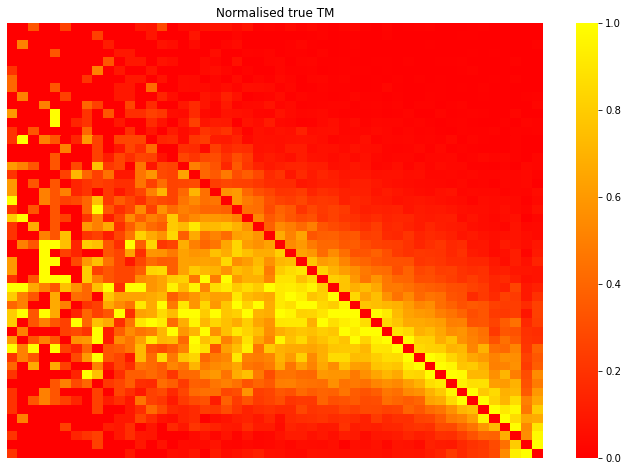

In [102]:
tmrca_data1 = get_coal_data(sim1, args) # get true coalescent 
coal_times_absolute1 = round_bin_coal_data(sim1.sequence_length,tmrca_data1, args) # partition coalescent data into bins  
coal_times1 = coal_times_absolute1/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals1 = round_coal_times(coal_times1,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm1 = tm_counts(coal_times_intervals1,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd1 = np.copy(tm1)
tm_nd1[range(0,len(tm1)),range(0,len(tm1))] = 0
tm_nd_norm1 = normalise(tm_nd1,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd1,'colmax'),title='Normalised true TM') # show heatmap


In [103]:
# print('tmrca_data1 is {}'.format(tmrca_data1))
# print('coal_times_absolute1 is {}'.format(coal_times_absolute1))  
# print('coal_times1 is {}'.format(coal_times1))
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
print('coal_times_intervals1 is {}'.format(coal_times_intervals1[0:50] ))

coal_times_intervals1 is [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


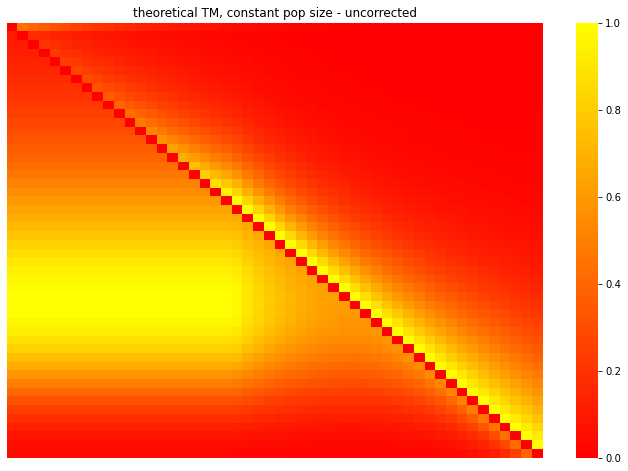

In [104]:
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2A, q_2_upperA, q_2_lowerA, q_1A, q_A = abinitio(T_np,50,pop_size1,N_0)
# type(T_np)
heatmaps_seq(normalise(q_2A,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think there is a mistake in Schiffels' equation 26, see my notepad page 12 and 13. Below I implement what i believe to be the correction

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


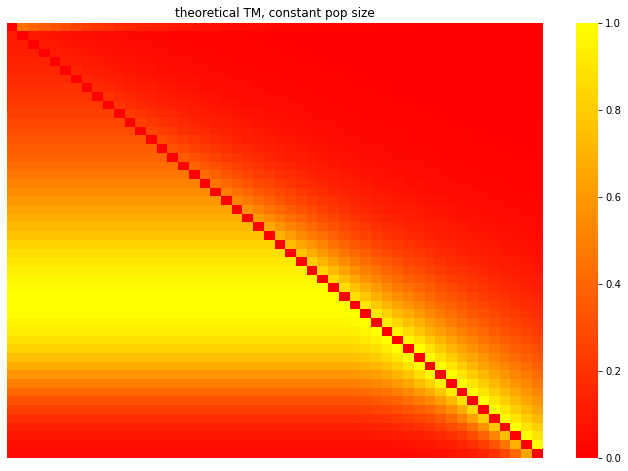

In [106]:
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Ac,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperAc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

In [108]:
q_A

array([[9.99985922e-01, 5.28297031e-07, 5.28296113e-07, ...,
        5.27232304e-07, 5.27113058e-07, 5.26980657e-07],
       [5.79112389e-08, 9.99969675e-01, 2.39391662e-07, ...,
        2.38909609e-07, 2.38855574e-07, 2.38795578e-07],
       [6.41119668e-08, 1.36253635e-07, 9.99966251e-01, ...,
        2.94068791e-07, 2.94002281e-07, 2.93928433e-07],
       ...,
       [4.84502496e-08, 1.02968650e-07, 1.14496503e-07, ...,
        9.96724318e-01, 3.47986926e-04, 3.47899518e-04],
       [3.05041418e-08, 6.48287742e-08, 7.20866785e-08, ...,
        1.34405537e-04, 9.96451007e-01, 3.79787323e-04],
       [1.80275378e-08, 3.83129341e-08, 4.26022580e-08, ...,
        7.94318656e-05, 1.39854403e-04, 9.96211930e-01]])

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


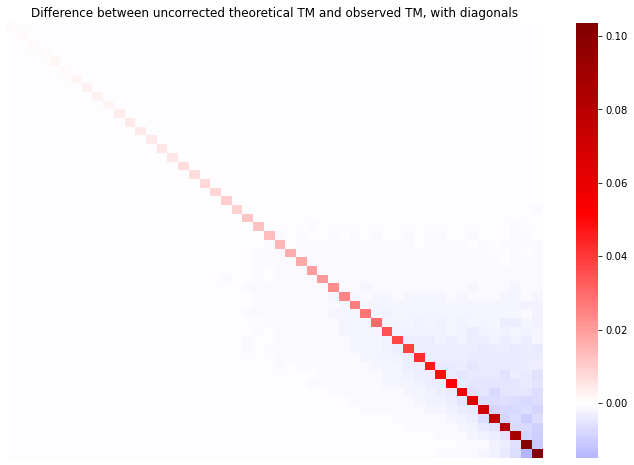

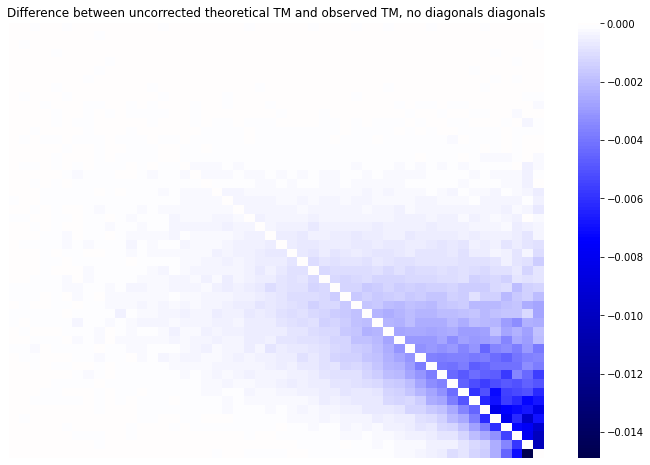

In [109]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_1 = normalise(tm1,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_tmA = q_A - tm_1
diff_q_tm_ndA = np.copy(diff_q_tmA)
diff_q_tm_ndA = remove_diagonals(diff_q_tm_ndA)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmA,title="Difference between uncorrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndA,title="Difference between uncorrected theoretical TM and observed TM, no diagonals diagonals")


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


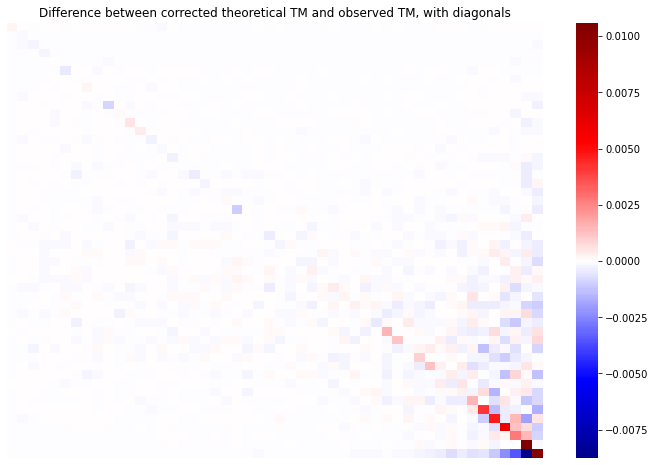

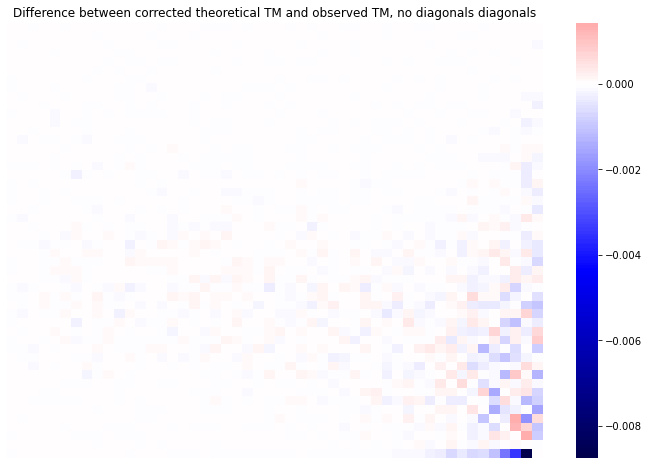

In [110]:

diff_q_tmAc = q_Ac - tm_1
diff_q_tm_ndAc = np.copy(diff_q_tmAc)
diff_q_tm_ndAc = remove_diagonals(diff_q_tm_ndAc)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmAc,title="Difference between corrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndAc,title="Difference between corrected theoretical TM and observed TM, no diagonals diagonals")


Now compare correction vs uncorrection

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


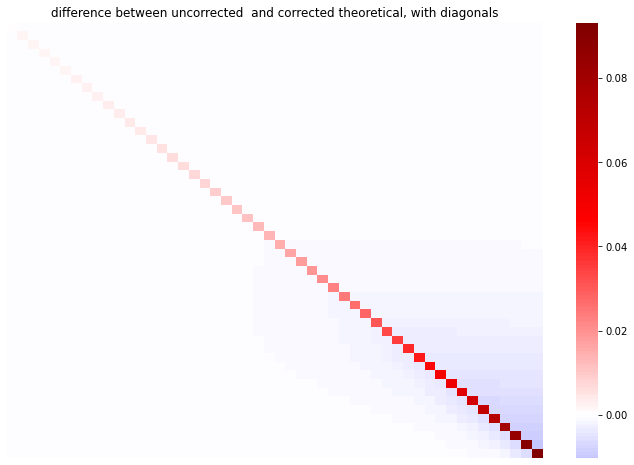

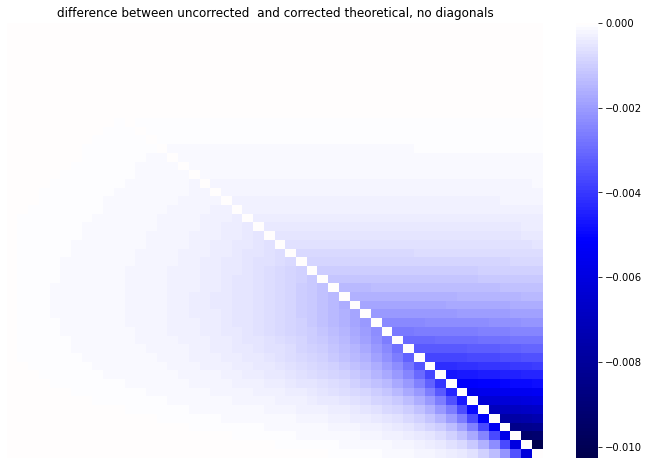

In [111]:

diff_q_A_q_Ac = q_A - q_Ac
diff_q_A_q_Ac_nd = np.copy(diff_q_A_q_Ac)
diff_q_A_q_Ac_nd = remove_diagonals(diff_q_A_q_Ac_nd)

heatmaps_div(diff_q_A_q_Ac,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_A_q_Ac_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

## Comparison for panmictic population of changing size

Compare observations against theoretical

In [73]:
sim2 = psc_pop(150e+06)


Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 40000.0
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 40000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


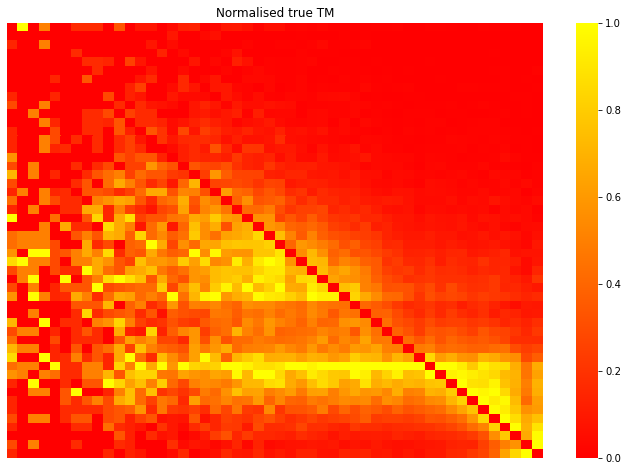

In [37]:
tmrca_data2 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


In [20]:
[T_np*2*N_0][0][33:40]

array([21916.99408938, 24369.40421542, 27096.22767576, 30128.17005154,
       33499.37273618, 37247.79738688, 41415.65339448])

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


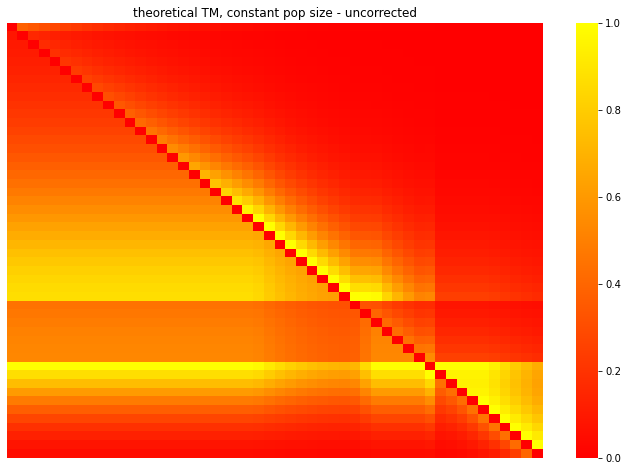

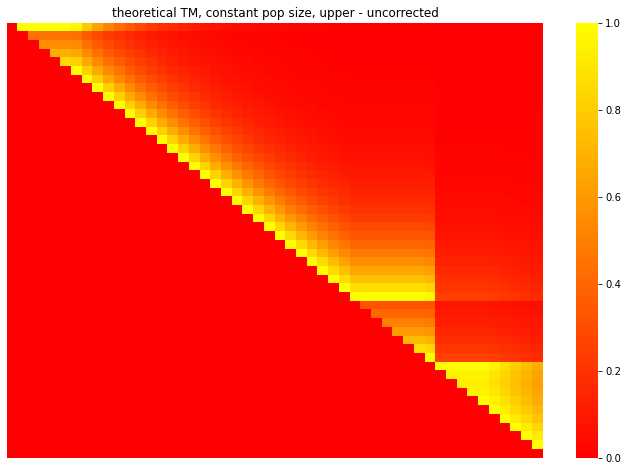

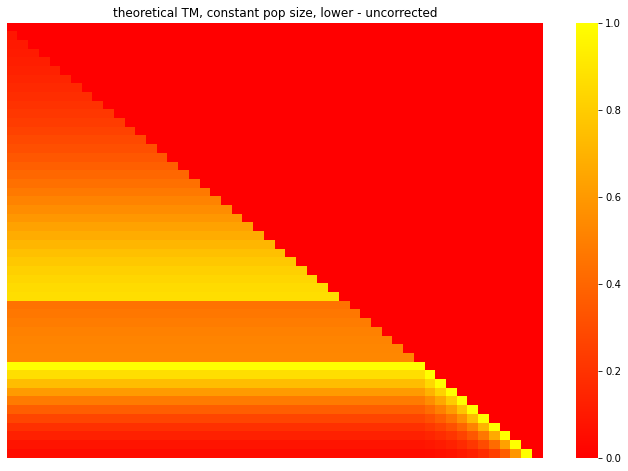

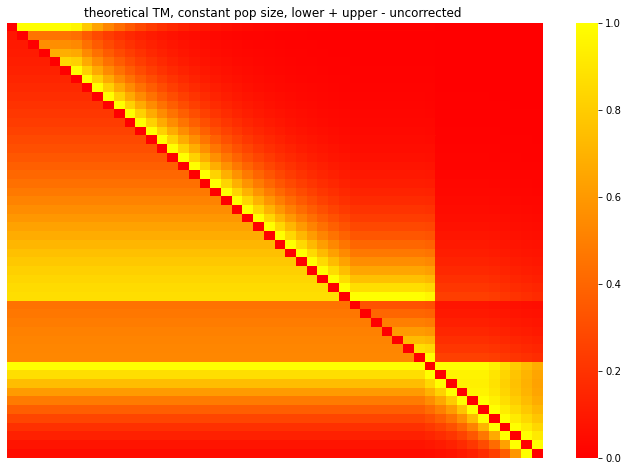

In [49]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2B, q_2_upperB, q_2_lowerB, q_1B, q_B = abinitio(T_np,50,pop_size2,N_0)
# type(T_np)
heatmaps_seq(normalise(q_2B,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerB,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerB,'colmax')+normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think I spotted a mistake in equation 26 ( missing factor of (1/(2*lambda_alpha)), see my notedpad page 12 and 13), so I have tried to correct it

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


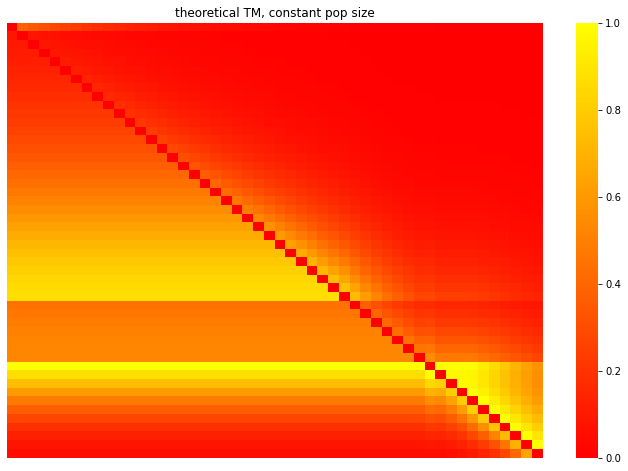

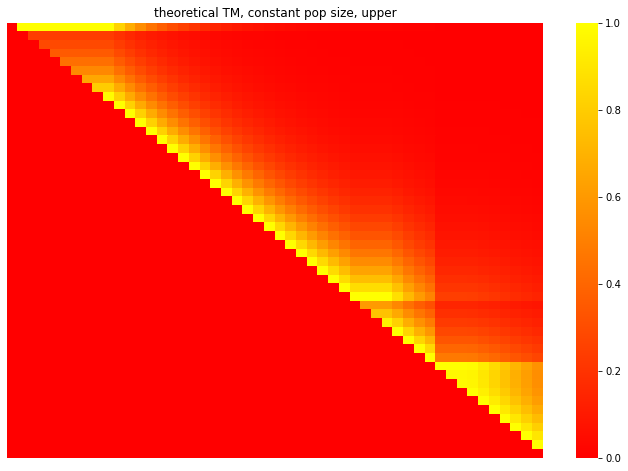

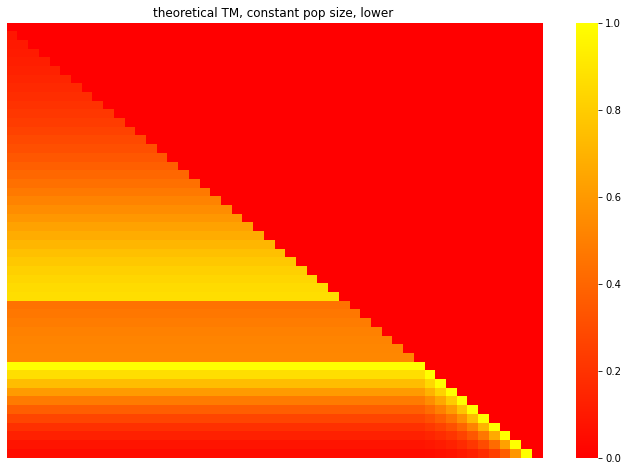

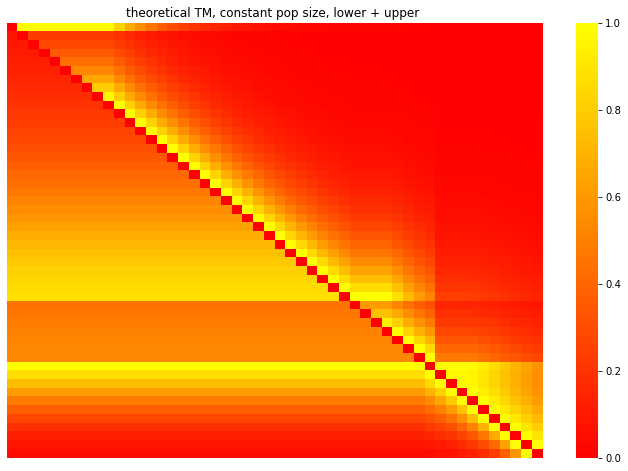

In [50]:
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

Comparison between (un)corrected TM and observation

In [51]:
tm_2

array([[0.00000000e+00, 3.10559006e-04, 0.00000000e+00, ...,
        6.30676085e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.50940956e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.88552793e-03, 1.02000785e-02],
       [1.90188191e-05, 0.00000000e+00, 9.71534052e-05, ...,
        5.54994955e-03, 0.00000000e+00, 1.03570027e-02],
       [9.50940956e-06, 0.00000000e+00, 0.00000000e+00, ...,
        8.13572149e-03, 1.33282919e-02, 0.00000000e+00]])

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


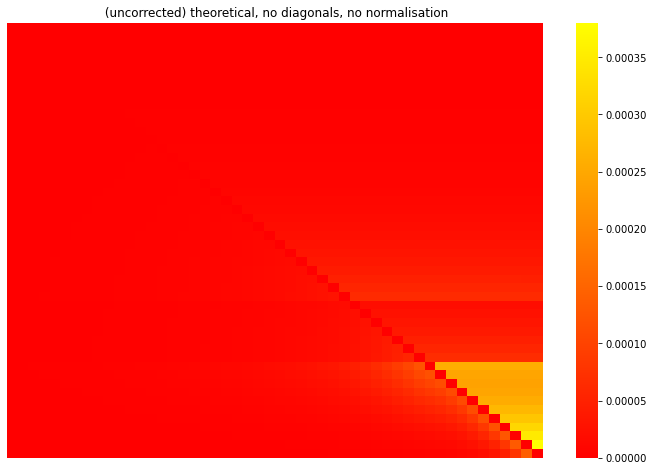

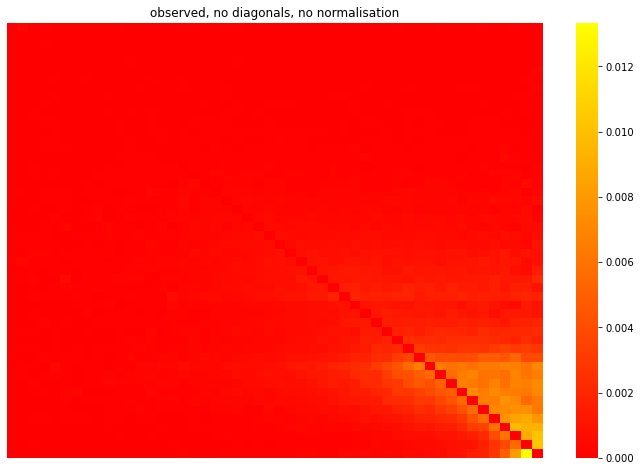

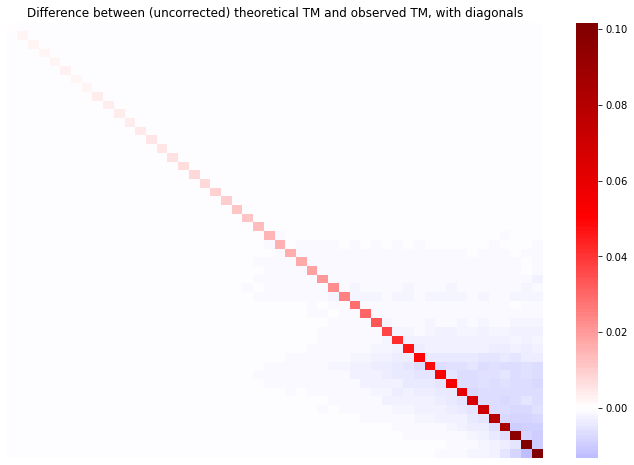

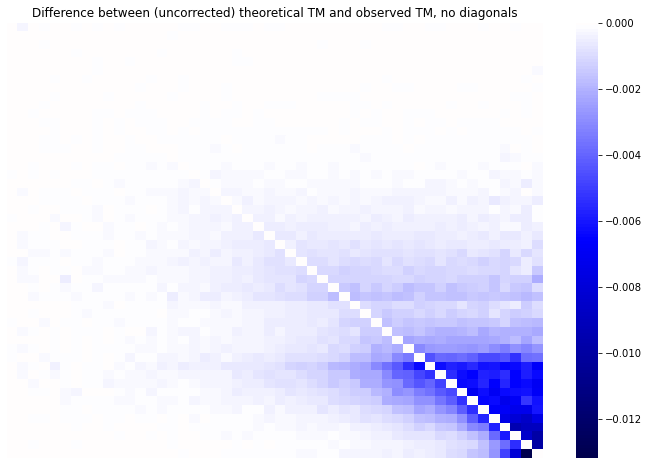

In [53]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_B_tm2 = q_B - tm_2
diff_q_B_tm_nd2 = np.copy(diff_q_B_tm2)
diff_q_B_tm_nd2 = remove_diagonals(diff_q_B_tm_nd2)

heatmaps_seq(q_2B,title=" (uncorrected) theoretical, no diagonals, no normalisation")
heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_B_tm2,title="Difference between (uncorrected) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_B_tm_nd2,title="Difference between (uncorrected) theoretical TM and observed TM, no diagonals")


Comparison between corrected TM and observation

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


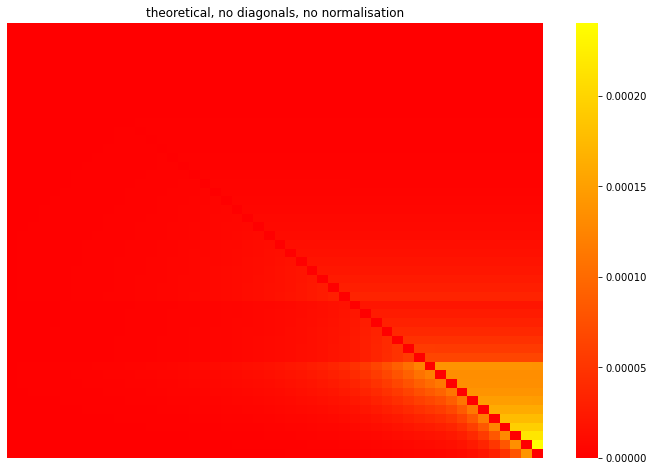

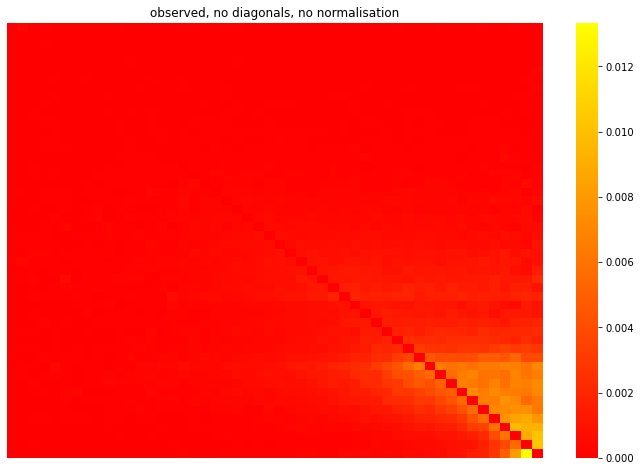

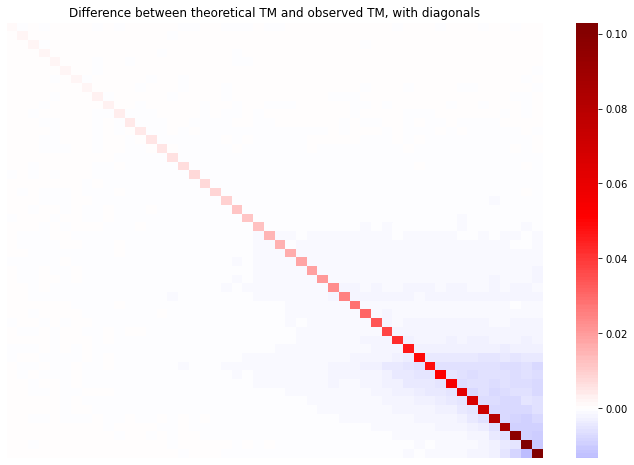

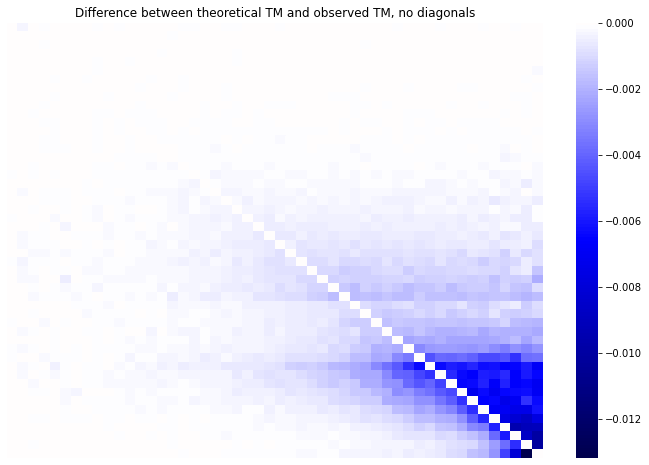

In [54]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


Difference between uncorrected and corrected theoretical  TM

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


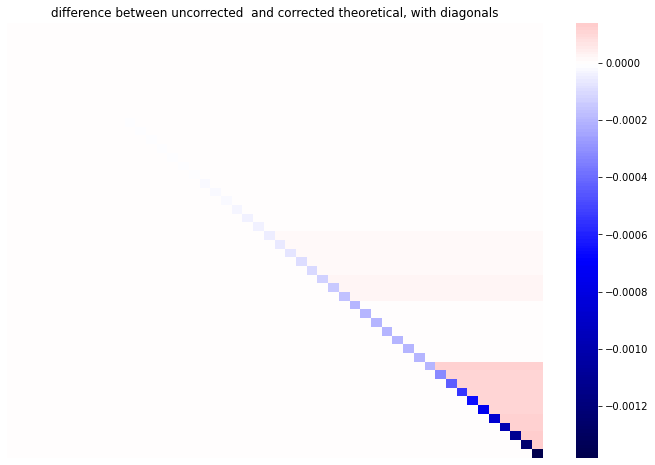

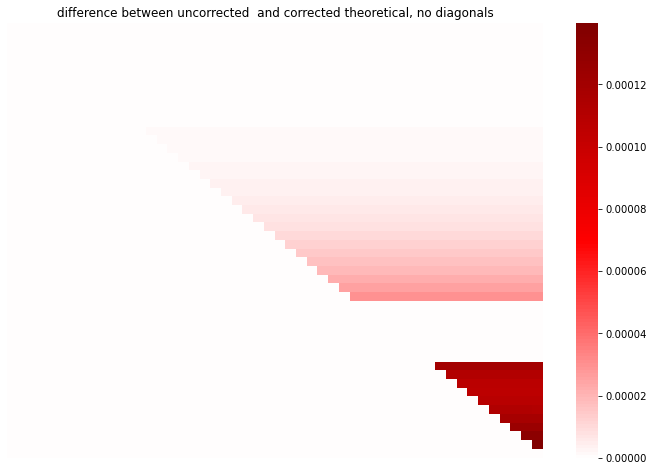

In [71]:

diff_q_B_q_Bc = q_B - q_Bc
diff_q_B_q_Bc_nd = np.copy(diff_q_B_q_Bc)
diff_q_B_q_Bc_nd = remove_diagonals(diff_q_B_q_Bc_nd)

heatmaps_div(diff_q_B_q_Bc,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_B_q_Bc_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

## Investigating the bad diagonals stuff

I think this is  because of the binning of the genome I do; i.e. I divide the genome into bins of 100bp (or something) and count the transitions between these parts. Therefore most adjacent bins have the same the tMRCA. 

The theory gives a probability of recombining or not ((1 -exp(-2rs)) or (exp(-2rs)) , but I am unsure how it measures not recombining in adjacent segments? Hmmm. Think it says "either there has been no recombination, or there has been a recombination but the tMRCA is the same".

First I try adjusting the bin size.

##### The defaultl bin size used in the above analysis was: 50, I will fiddle with this now and see how things differ

Now I will change that and see how results differ

In [84]:
args.bin_length = 50

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


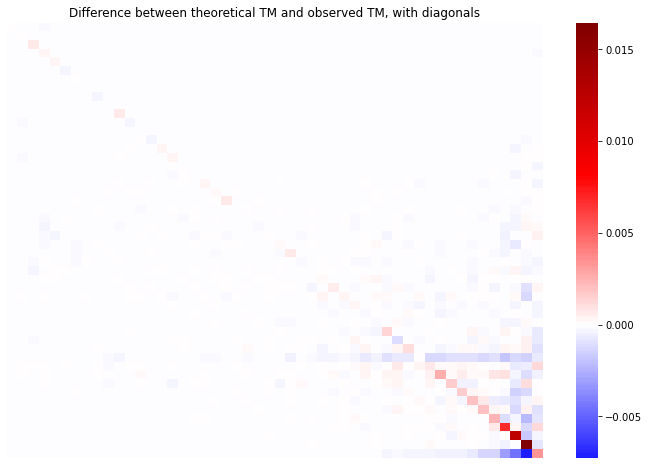

In [85]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [86]:
args.bin_length=20

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


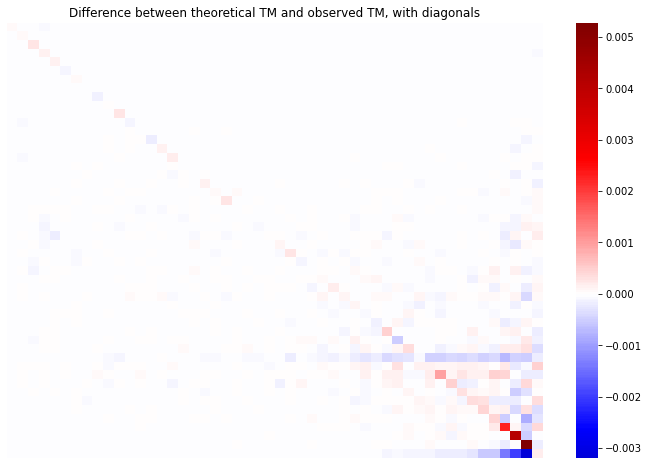

In [89]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [92]:
args.bin_length = 10

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


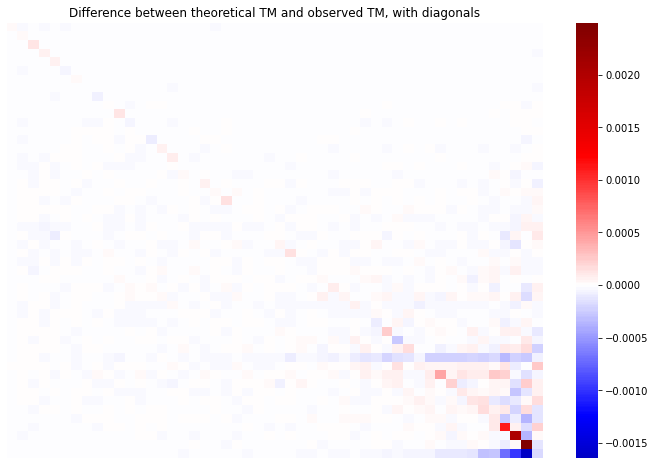

In [93]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [94]:
args.bin_length = 2

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


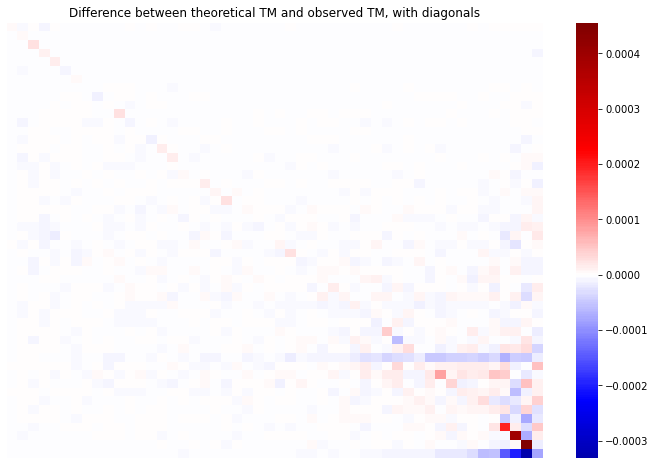

In [95]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [70]:
sim2

NameError: name 'sim2' is not defined

## TODO

Make a more effecient algorithm for getting this observed coalescent data
Or, as per what Aylwyn said, sort out recombination rate; the binning therefore could remain as 50 (or 100 or whatever) but then we'd have to alter the recombination rate, which i had given as 2e-08 in all my simulations. 

## Try out G function, as written in Distribution of coalesent times -Copy_210116

I will copy paste from the above notebook. I copy as of 2021/01/29 (ymd) - I hope that i don't change things in one script and not the other! 

In [37]:
def G(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def delta(i):
        delt = T[i+1] - T[i]
        return delt
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
  

I now need to rewrite my transition matrix theory with this function instead of L. In my notepad, page 15-17, I write what I expect the theoretical probabilities to be. They are cumbersome so I introduced new functions called H instead. I will also write that in the above block of code. 

Note that my G function is calibrated to run from t1=0 to t2 - i.e. it should be given G(0,t2)<br>.
Therefore, if you want a non t1!=0 start, you should do G(t1,t2)/G(0,t1) 

In [60]:
def structuredsplit_abinitio(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    
    def lambda_(int):
            lambd = lambda_array[int]
            return lambd
    
    def sigma(int):
        sig = (1-gamma_array[int])**2 + gamma_array[int]**2
        return sig
    
    def H_intervals(ind1): # for iterating through the intervals
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/gamma)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H

    def H_edge(ind1,t): # for the edge case where the upper boundary is t2, not an interval
        if t2 < T[ind1]:
            print('There has been an error! T[ind] is bigger than t2, whereas t2 should be bigger than T[ind]')
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = t - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/gamma)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H

    def H_antidash(ind1): # let this be the integral of H, i.e. the antiderivate, i.e. the anti' of H - poor naming i know
        sig = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma_ = gamma_array[ind1]
        lambd = lambda_array[ind1]
        delt = T[ind1+1] - T[ind1]
        if sig==1:
            H = (1/(2*lambd))*(delt - (1/(2*lambd))*(1-np.exp(-2*delt*lambd)))
        else: 
            delt = T[ind1+1] - T[ind1]
            H = ((1-sig)**2)*( (T[ind1+1]**2 - T[ind1]**2)/2 + T[ind1]*delt) + 2*(1-sig)*(sig/lambd)*(
                delt + (1/lambd)*(np.exp(-lambd*delt) - 1)
            ) + (((sig)**2)/(2*lambd))*(
            delt + (1/(2*lambd))*(np.exp(-2*lambd*delt) -1))
        return H
    
    def delta(int):
        delt = T[int+1] - T[int]
        return delt
    
    def delta_(int):
        delt = T[int+1] - T[int]
        return delt

    
    def expected_time(int):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix

    
    def upper_diag_sum(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = G(T[j+1],T[alpha],gamma_array,lambda_array,T_np)**2 * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
        
    def upper_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(alpha+1,N_T):
#                 if alpha ==1:
#                     pdb.set_trace()
                q_2[alpha,beta] = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha) * (
                    upper_diag_sum(alpha)*H_intervals(alpha) + H_antidash(alpha)               
                )
                pre = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha)
                A = upper_diag_sum(alpha)*H_intervals(alpha)
                B = H_antidash(alpha)
                print('\n\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    

    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    q_2 = upper_diag(q_2)
    return q_2
    
    

In [12]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

# print(f'T_np is {T_np}\n\n')
# print(f'T_scaled_np is {T_scaled_np}')

In [13]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

# gamma_array[20:35] = 0.3

In [66]:
q_2 = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array)

expected_times conforms with T.


For alpha  0 and beta 1 we have q_2[alpha,beta] = 5.282970312706966e-07
with pre = 0.000799987569813952
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 2 we have q_2[alpha,beta] = 5.282961128064066e-07
with pre = 0.000799986179005426
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 3 we have q_2[alpha,beta] = 5.282950915820396e-07
with pre = 0.0007999846325897712
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 4 we have q_2[alpha,beta] = 5.282939561019236e-07
with pre = 0.0007999829131593658
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 5 we have q_2[alpha,beta] = 5.282926935834519e-07
with pre = 0.0007999810013578144
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 6 we have q_2[alpha,beta] = 5.282912898153333e-07
with pre = 0.0007999788756652981
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 7 we have q_2[alpha,beta] = 5.282897289999175e-07
with pre = 0.0007999765121598126



For alpha  6 and beta 26 we have q_2[alpha,beta] = 3.460332774607671e-07
with pre = 0.0007998238801444498
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 27 we have q_2[alpha,beta] = 3.4602475776590436e-07
with pre = 0.0007998041876586498
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 28 we have q_2[alpha,beta] = 3.460152862393154e-07
with pre = 0.0007997822951019487
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 29 we have q_2[alpha,beta] = 3.460047567257079e-07
with pre = 0.0007997579571062179
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 30 we have q_2[alpha,beta] = 3.459930512737157e-07
with pre = 0.0007997309010377959
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 31 we have q_2[alpha,beta] = 3.4598003883608797e-07
with pre = 0.0007997008239930968
A = 0.00040827997940467883
and B = 2.4356862343873076e-05






For alpha  9 and beta 31 we have q_2[alpha,beta] = 6.382117594256311e-07
with pre = 0.0007997008239930968
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 32 we have q_2[alpha,beta] = 6.381850765615537e-07
with pre = 0.0007996673894659606
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 33 we have q_2[alpha,beta] = 6.381554158987922e-07
with pre = 0.0007996302236568068
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 34 we have q_2[alpha,beta] = 6.381224460964224e-07
with pre = 0.0007995889113843007
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 35 we have q_2[alpha,beta] = 6.38085799175738e-07
with pre = 0.0007995429915587328
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 36 we have q_2[alpha,beta] = 6.380450665235875e-07
with pre = 0.000799491952174066
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 37 we have q



For alpha  11 and beta 41 we have q_2[alpha,beta] = 9.547914877574271e-07
with pre = 0.0007991377285596813
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 42 we have q_2[alpha,beta] = 9.546766260901807e-07
with pre = 0.0007990415920806293
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 43 we have q_2[alpha,beta] = 9.545490095230947e-07
with pre = 0.0007989347800542808
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 44 we have q_2[alpha,beta] = 9.544072336211276e-07
with pre = 0.000798816117001965
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 45 we have q_2[alpha,beta] = 9.542497420432333e-07
with pre = 0.0007986843003033042
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 46 we have q_2[alpha,beta] = 9.540748107149818e-07
with pre = 0.000798537886949074
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha 



For alpha  13 and beta 32 we have q_2[alpha,beta] = 1.4236720673825887e-06
with pre = 0.0007996673894659606
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 33 we have q_2[alpha,beta] = 1.4236058999671722e-06
with pre = 0.0007996302236568068
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 34 we have q_2[alpha,beta] = 1.4235323504774945e-06
with pre = 0.0007995889113843007
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 35 we have q_2[alpha,beta] = 1.4234505980215845e-06
with pre = 0.0007995429915587328
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 36 we have q_2[alpha,beta] = 1.4233597310595902e-06
with pre = 0.000799491952174066
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 37 we have q_2[alpha,beta] = 1.423258737543077e-06
with pre = 0.0007994352247692419
A = 0.0016733523932083853
and B = 0.00010697788677634101




For alpha  15 and beta 16 we have q_2[alpha,beta] = 2.1100977296420887e-06
with pre = 0.0007999389961649854
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 17 we have q_2[alpha,beta] = 2.110079728327513e-06
with pre = 0.0007999321718585521
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 18 we have q_2[alpha,beta] = 2.1100597138338097e-06
with pre = 0.0007999245843550081
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 19 we have q_2[alpha,beta] = 2.110037461151032e-06
with pre = 0.0007999161483529817
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 20 we have q_2[alpha,beta] = 2.1100127201548593e-06
with pre = 0.0007999067690302306
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 21 we have q_2[alpha,beta] = 2.1099852128058378e-06
with pre = 0.0007998963409818734
A = 0.002474687420767174
and B = 0.00016313588795784095


For 



For alpha  17 and beta 32 we have q_2[alpha,beta] = 3.1040037009082e-06
with pre = 0.0007996673894659606
A = 0.003632978885758021
and B = 0.00024863957436342676


For alpha  17 and beta 33 we have q_2[alpha,beta] = 3.1038594374173032e-06
with pre = 0.0007996302236568068
A = 0.003632978885758021
and B = 0.00024863957436342676


For alpha  17 and beta 34 we have q_2[alpha,beta] = 3.103699078937714e-06
with pre = 0.0007995889113843007
A = 0.003632978885758021
and B = 0.00024863957436342676


For alpha  17 and beta 35 we have q_2[alpha,beta] = 3.103520835695104e-06
with pre = 0.0007995429915587328
A = 0.003632978885758021
and B = 0.00024863957436342676


For alpha  17 and beta 36 we have q_2[alpha,beta] = 3.1033227202773883e-06
with pre = 0.000799491952174066
A = 0.003632978885758021
and B = 0.00024863957436342676


For alpha  17 and beta 37 we have q_2[alpha,beta] = 3.1031025261356282e-06
with pre = 0.0007994352247692419
A = 0.003632978885758021
and B = 0.00024863957436342676


For alph



For alpha  19 and beta 39 we have q_2[alpha,beta] = 4.5281581683639124e-06
with pre = 0.00079930211240858
A = 0.0052864342504621254
and B = 0.00037870549841076406


For alpha  19 and beta 40 we have q_2[alpha,beta] = 4.527717066355145e-06
with pre = 0.0007992242498970938
A = 0.0052864342504621254
and B = 0.00037870549841076406


For alpha  19 and beta 41 we have q_2[alpha,beta] = 4.527226910887444e-06
with pre = 0.0007991377285596813
A = 0.0052864342504621254
and B = 0.00037870549841076406


For alpha  19 and beta 42 we have q_2[alpha,beta] = 4.52668228429865e-06
with pre = 0.0007990415920806293
A = 0.0052864342504621254
and B = 0.00037870549841076406


For alpha  19 and beta 43 we have q_2[alpha,beta] = 4.526077179242525e-06
with pre = 0.0007989347800542808
A = 0.0052864342504621254
and B = 0.00037870549841076406


For alpha  19 and beta 44 we have q_2[alpha,beta] = 4.525404936468129e-06
with pre = 0.000798816117001965
A = 0.0052864342504621254
and B = 0.00037870549841076406


For a



For alpha  21 and beta 37 we have q_2[alpha,beta] = 6.545594952707961e-06
with pre = 0.0007994352247692419
A = 0.007611437029245156
and B = 0.000576336976581715


For alpha  21 and beta 38 we have q_2[alpha,beta] = 6.5450787425180144e-06
with pre = 0.0007993721783063596
A = 0.007611437029245156
and B = 0.000576336976581715


For alpha  21 and beta 39 we have q_2[alpha,beta] = 6.5445050587814795e-06
with pre = 0.00079930211240858
A = 0.007611437029245156
and B = 0.000576336976581715


For alpha  21 and beta 40 we have q_2[alpha,beta] = 6.543867538133905e-06
with pre = 0.0007992242498970938
A = 0.007611437029245156
and B = 0.000576336976581715


For alpha  21 and beta 41 we have q_2[alpha,beta] = 6.5431591209764895e-06
with pre = 0.0007991377285596813
A = 0.007611437029245156
and B = 0.000576336976581715


For alpha  21 and beta 42 we have q_2[alpha,beta] = 6.542371977212296e-06
with pre = 0.0007990415920806293
A = 0.007611437029245156
and B = 0.000576336976581715


For alpha  21 and b



For alpha  24 and beta 27 we have q_2[alpha,beta] = 1.1129670801748178e-05
with pre = 0.0007998041876586498
A = 0.012835589749432236
and B = 0.0010799047847102061


For alpha  24 and beta 28 we have q_2[alpha,beta] = 1.1129366155995065e-05
with pre = 0.0007997822951019487
A = 0.012835589749432236
and B = 0.0010799047847102061


For alpha  24 and beta 29 we have q_2[alpha,beta] = 1.1129027480748501e-05
with pre = 0.0007997579571062179
A = 0.012835589749432236
and B = 0.0010799047847102061


For alpha  24 and beta 30 we have q_2[alpha,beta] = 1.112865098217626e-05
with pre = 0.0007997309010377959
A = 0.012835589749432236
and B = 0.0010799047847102061


For alpha  24 and beta 31 we have q_2[alpha,beta] = 1.1128232445225146e-05
with pre = 0.0007997008239930968
A = 0.012835589749432236
and B = 0.0010799047847102061


For alpha  24 and beta 32 we have q_2[alpha,beta] = 1.112776718724553e-05
with pre = 0.0007996673894659606
A = 0.012835589749432236
and B = 0.0010799047847102061


For alpha 



For alpha  26 and beta 34 we have q_2[alpha,beta] = 1.55725381079315e-05
with pre = 0.0007995889113843007
A = 0.017837099683493653
and B = 0.0016385807395518648


For alpha  26 and beta 35 we have q_2[alpha,beta] = 1.5571643788083658e-05
with pre = 0.0007995429915587328
A = 0.017837099683493653
and B = 0.0016385807395518648


For alpha  26 and beta 36 we have q_2[alpha,beta] = 1.55706497613389e-05
with pre = 0.000799491952174066
A = 0.017837099683493653
and B = 0.0016385807395518648


For alpha  26 and beta 37 we have q_2[alpha,beta] = 1.5569544956531316e-05
with pre = 0.0007994352247692419
A = 0.017837099683493653
and B = 0.0016385807395518648


For alpha  26 and beta 38 we have q_2[alpha,beta] = 1.556831708376842e-05
with pre = 0.0007993721783063596
A = 0.017837099683493653
and B = 0.0016385807395518648


For alpha  26 and beta 39 we have q_2[alpha,beta] = 1.556695250273471e-05
with pre = 0.00079930211240858
A = 0.017837099683493653
and B = 0.0016385807395518648


For alpha  26 and



For alpha  29 and beta 33 we have q_2[alpha,beta] = 2.5011053954944226e-05
with pre = 0.0007996302236568068
A = 0.028225703833660267
and B = 0.003052571067663018


For alpha  29 and beta 34 we have q_2[alpha,beta] = 2.5009761778327983e-05
with pre = 0.0007995889113843007
A = 0.028225703833660267
and B = 0.003052571067663018


For alpha  29 and beta 35 we have q_2[alpha,beta] = 2.500832548540045e-05
with pre = 0.0007995429915587328
A = 0.028225703833660267
and B = 0.003052571067663018


For alpha  29 and beta 36 we have q_2[alpha,beta] = 2.5006729061496047e-05
with pre = 0.000799491952174066
A = 0.028225703833660267
and B = 0.003052571067663018


For alpha  29 and beta 37 we have q_2[alpha,beta] = 2.500495472613352e-05
with pre = 0.0007994352247692419
A = 0.028225703833660267
and B = 0.003052571067663018


For alpha  29 and beta 38 we have q_2[alpha,beta] = 2.500298274153593e-05
with pre = 0.0007993721783063596
A = 0.028225703833660267
and B = 0.003052571067663018


For alpha  29 and 



For alpha  32 and beta 39 we have q_2[alpha,beta] = 3.8564274739343104e-05
with pre = 0.00079930211240858
A = 0.04258999324137741
and B = 0.005657439288401983


For alpha  32 and beta 40 we have q_2[alpha,beta] = 3.8560518073073573e-05
with pre = 0.0007992242498970938
A = 0.04258999324137741
and B = 0.005657439288401983


For alpha  32 and beta 41 we have q_2[alpha,beta] = 3.8556343640684384e-05
with pre = 0.0007991377285596813
A = 0.04258999324137741
and B = 0.005657439288401983


For alpha  32 and beta 42 we have q_2[alpha,beta] = 3.855170530239767e-05
with pre = 0.0007990415920806293
A = 0.04258999324137741
and B = 0.005657439288401983


For alpha  32 and beta 43 we have q_2[alpha,beta] = 3.854655189636305e-05
with pre = 0.0007989347800542808
A = 0.04258999324137741
and B = 0.005657439288401983


For alpha  32 and beta 44 we have q_2[alpha,beta] = 3.854082670875267e-05
with pre = 0.000798816117001965
A = 0.04258999324137741
and B = 0.005657439288401983


For alpha  32 and beta 45 



For alpha  36 and beta 42 we have q_2[alpha,beta] = 6.453335649023085e-05
with pre = 0.0007990415920806293
A = 0.06802763782414654
and B = 0.012735813202466528


For alpha  36 and beta 43 we have q_2[alpha,beta] = 6.45247299823718e-05
with pre = 0.0007989347800542808
A = 0.06802763782414654
and B = 0.012735813202466528


For alpha  36 and beta 44 we have q_2[alpha,beta] = 6.451514634475743e-05
with pre = 0.000798816117001965
A = 0.06802763782414654
and B = 0.012735813202466528


For alpha  36 and beta 45 we have q_2[alpha,beta] = 6.450450037327064e-05
with pre = 0.0007986843003033042
A = 0.06802763782414654
and B = 0.012735813202466528


For alpha  36 and beta 46 we have q_2[alpha,beta] = 6.449267552550662e-05
with pre = 0.000798537886949074
A = 0.06802763782414654
and B = 0.012735813202466528


For alpha  36 and beta 47 we have q_2[alpha,beta] = 6.447954274751246e-05
with pre = 0.0007983752790140834
A = 0.06802763782414654
and B = 0.012735813202466528


For alpha  36 and beta 48 we 



For alpha  41 and beta 43 we have q_2[alpha,beta] = 0.00011391375709179388
with pre = 0.0007989347800542808
A = 0.10838141130775487
and B = 0.03420063660866507


For alpha  41 and beta 44 we have q_2[alpha,beta] = 0.00011389683787078268
with pre = 0.000798816117001965
A = 0.10838141130775487
and B = 0.03420063660866507


For alpha  41 and beta 45 we have q_2[alpha,beta] = 0.00011387804317593804
with pre = 0.0007986843003033042
A = 0.10838141130775487
and B = 0.03420063660866507


For alpha  41 and beta 46 we have q_2[alpha,beta] = 0.00011385716726004958
with pre = 0.000798537886949074
A = 0.10838141130775487
and B = 0.03420063660866507


For alpha  41 and beta 47 we have q_2[alpha,beta] = 0.00011383398228767116
with pre = 0.0007983752790140834
A = 0.10838141130775487
and B = 0.03420063660866507


For alpha  41 and beta 48 we have q_2[alpha,beta] = 0.00011380823606581003
with pre = 0.0007981947077413505
A = 0.10838141130775487
and B = 0.03420063660866507


For alpha  41 and beta 49 we

In [67]:
# should be 
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0)

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.


For alpha  0 and beta 1 we have q_2[alpha,beta] = 5.282970312706966e-07
with pre = 0.000799987569813952
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 2 we have q_2[alpha,beta] = 5.282961128064066e-07
with pre = 0.000799986179005426
A = 0



For alpha  9 and beta 43 we have q_2[alpha,beta] = 6.376004079860417e-07
with pre = 0.0007989347800542808
A = 0.0007521171074560202
and B = 4.59460435094719e-05


For alpha  9 and beta 44 we have q_2[alpha,beta] = 6.375057073766074e-07
with pre = 0.000798816117001965
A = 0.0007521171074560202
and B = 4.59460435094719e-05


For alpha  9 and beta 45 we have q_2[alpha,beta] = 6.374005093267242e-07
with pre = 0.0007986843003033042
A = 0.0007521171074560202
and B = 4.59460435094719e-05


For alpha  9 and beta 46 we have q_2[alpha,beta] = 6.372836622239039e-07
with pre = 0.000798537886949074
A = 0.0007521171074560202
and B = 4.59460435094719e-05


For alpha  9 and beta 47 we have q_2[alpha,beta] = 6.371538908229333e-07
with pre = 0.0007983752790140834
A = 0.0007521171074560202
and B = 4.59460435094719e-05


For alpha  9 and beta 48 we have q_2[alpha,beta] = 6.370097835440422e-07
with pre = 0.0007981947077413505
A = 0.0007521171074560202
and B = 4.59460435094719e-05


For alpha  9 and beta 



For alpha  17 and beta 24 we have q_2[alpha,beta] = 3.104741738599089e-06
with pre = 0.0007998575260542088
A = 0.0036329788857580214
and B = 0.00024863957436342676


For alpha  17 and beta 25 we have q_2[alpha,beta] = 3.1046798940148995e-06
with pre = 0.0007998415933743679
A = 0.0036329788857580214
and B = 0.00024863957436342676


For alpha  17 and beta 26 we have q_2[alpha,beta] = 3.104611138014661e-06
with pre = 0.0007998238801444498
A = 0.0036329788857580214
and B = 0.00024863957436342676


For alpha  17 and beta 27 we have q_2[alpha,beta] = 3.104534699298254e-06
with pre = 0.0007998041876586498
A = 0.0036329788857580214
and B = 0.00024863957436342676


For alpha  17 and beta 28 we have q_2[alpha,beta] = 3.1044497207460237e-06
with pre = 0.0007997822951019487
A = 0.0036329788857580214
and B = 0.00024863957436342676


For alpha  17 and beta 29 we have q_2[alpha,beta] = 3.1043552499325126e-06
with pre = 0.0007997579571062179
A = 0.0036329788857580214
and B = 0.00024863957436342676





For alpha  23 and beta 47 we have q_2[alpha,beta] = 9.339851531550518e-06
with pre = 0.0007983752790140834
A = 0.010822354206322726
and B = 0.0008762188545620442


For alpha  23 and beta 48 we have q_2[alpha,beta] = 9.337739105323755e-06
with pre = 0.0007981947077413505
A = 0.010822354206322726
and B = 0.0008762188545620442


For alpha  23 and beta 49 we have q_2[alpha,beta] = 9.3353936393997e-06
with pre = 0.0007979942161162738
A = 0.010822354206322726
and B = 0.0008762188545620442


For alpha  24 and beta 25 we have q_2[alpha,beta] = 1.11301913207808e-05
with pre = 0.0007998415933743679
A = 0.012835589749432238
and B = 0.0010799047847102061


For alpha  24 and beta 26 we have q_2[alpha,beta] = 1.1129944832426693e-05
with pre = 0.0007998238801444498
A = 0.012835589749432238
and B = 0.0010799047847102061


For alpha  24 and beta 27 we have q_2[alpha,beta] = 1.1129670801748178e-05
with pre = 0.0007998041876586498
A = 0.012835589749432238
and B = 0.0010799047847102061


For alpha  24 a



For alpha  30 and beta 39 we have q_2[alpha,beta] = 2.9020190680609377e-05
with pre = 0.00079930211240858
A = 0.03255487380868473
and B = 0.0037520372204395136


For alpha  30 and beta 40 we have q_2[alpha,beta] = 2.9017363733332343e-05
with pre = 0.0007992242498970938
A = 0.03255487380868473
and B = 0.0037520372204395136


For alpha  30 and beta 41 we have q_2[alpha,beta] = 2.901422241083279e-05
with pre = 0.0007991377285596813
A = 0.03255487380868473
and B = 0.0037520372204395136


For alpha  30 and beta 42 we have q_2[alpha,beta] = 2.9010731992241196e-05
with pre = 0.0007990415920806293
A = 0.03255487380868473
and B = 0.0037520372204395136


For alpha  30 and beta 43 we have q_2[alpha,beta] = 2.9006853977503716e-05
with pre = 0.0007989347800542808
A = 0.03255487380868473
and B = 0.0037520372204395136


For alpha  30 and beta 44 we have q_2[alpha,beta] = 2.9002545688620844e-05
with pre = 0.000798816117001965
A = 0.03255487380868473
and B = 0.0037520372204395136


For alpha  30 and 



For alpha  37 and beta 47 we have q_2[alpha,beta] = 7.262706591415591e-05
with pre = 0.0007983752790140834
A = 0.07540857448058765
and B = 0.015560006114547192


For alpha  37 and beta 48 we have q_2[alpha,beta] = 7.261063960177913e-05
with pre = 0.0007981947077413505
A = 0.07540857448058765
and B = 0.015560006114547192


For alpha  37 and beta 49 we have q_2[alpha,beta] = 7.25924011632247e-05
with pre = 0.0007979942161162738
A = 0.07540857448058765
and B = 0.015560006114547192


For alpha  38 and beta 39 we have q_2[alpha,beta] = 8.164174384542667e-05
with pre = 0.00079930211240858
A = 0.08315432636584244
and B = 0.018986957359045042


For alpha  38 and beta 40 we have q_2[alpha,beta] = 8.163379086854942e-05
with pre = 0.0007992242498970938
A = 0.08315432636584244
and B = 0.018986957359045042


For alpha  38 and beta 41 we have q_2[alpha,beta] = 8.162495346807654e-05
with pre = 0.0007991377285596813
A = 0.08315432636584244
and B = 0.018986957359045042


For alpha  38 and beta 42 we 

Finished


In [92]:
print(q_2)

[[0.00000000e+00 5.28297031e-07 5.28296113e-07 ... 5.27232304e-07
  5.27113058e-07 5.26980657e-07]
 [0.00000000e+00 0.00000000e+00 6.75922249e-09 ... 6.74561172e-09
  6.74408604e-09 6.74239205e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.33711929e-09
  8.33523365e-09 8.33314000e-09]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.40791668e-05 8.40580477e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00516778e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [93]:
q_2[:,25]

array([5.28200631e-07, 6.75800086e-09, 8.35243143e-09, 1.03226860e-08,
       1.27572182e-08, 1.57652502e-08, 1.94816316e-08, 2.40728263e-08,
       2.97442903e-08, 3.67495566e-08, 4.54014209e-08, 5.60857037e-08,
       6.92781762e-08, 8.55653634e-08, 1.05670095e-07, 1.30482869e-07,
       1.61100305e-07, 1.98872273e-07, 2.45459566e-07, 3.02904409e-07,
       3.73716561e-07, 4.60978286e-07, 5.68472145e-07, 7.00836285e-07,
       8.63752764e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [85]:
q_2

array([[0.00000000e+00, 5.28297031e-07, 5.28296113e-07, ...,
        5.27232304e-07, 5.27113058e-07, 5.26980657e-07],
       [0.00000000e+00, 0.00000000e+00, 6.75922249e-09, ...,
        6.74561172e-09, 6.74408604e-09, 6.74239205e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.33711929e-09, 8.33523365e-09, 8.33314000e-09],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.40791668e-05, 8.40580477e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00516778e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


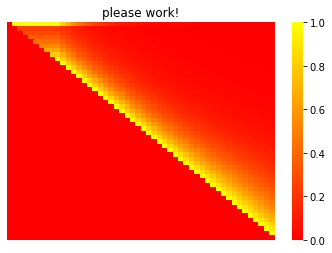

In [62]:
heatmaps_seq(normalise(q_2,'colmax'),title="please work!")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


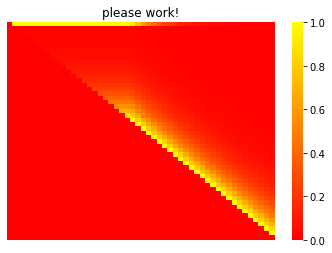

In [104]:
heatmaps_seq(normalise(q_2,'colmax'),title="please work!")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


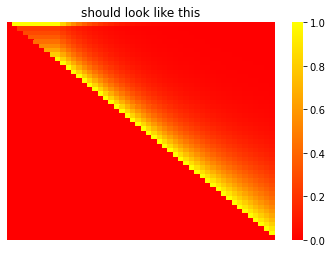

In [42]:
# should be 
# pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
# q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0)
heatmaps_seq(normalise(q_2_upperAc,'colmax'),title="should look like this")

Doesn't look too bad! TODO of course, though, fix this! 

In [68]:
checking_qs = q_2 - q_2_upperAc

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


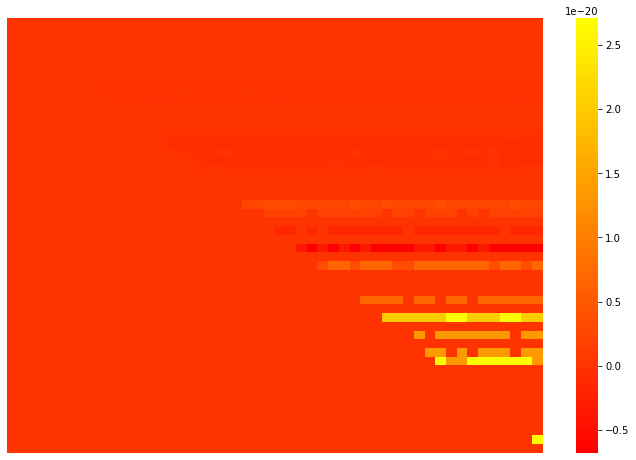

In [69]:
heatmaps_seq(checking_qs)